In [26]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from itertools import chain
import functools
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib,os
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#df = pd.read_pickle('/content/drive/MyDrive/ironhack_final_project/Imdb_doc2vec_v1.pckl')

In [ ]:
#df.shape

In [ ]:
#tfidf_df = pd.read_pickle('/content/drive/MyDrive/ironhack_final_project/Imdb_tfidf.pckl')

In [ ]:
#tfidf_df.shape

In [ ]:
#df = pd.concat([df, tfidf_df], axis=1)

In [ ]:
#df.shape

In [27]:
df = pd.read_pickle('/content/drive/MyDrive/ironhack_final_project/Imdb_db_cleaned_merged_final.pckl')

In [ ]:
df.shape

(50000, 5192)

In [ ]:
df.head(5)

,reviews,sentiment,review_clean,neg,neu,pos,compound,nb_char,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,word_aaron,word_abandon,word_abc,word_ability,word_able,word_aboard,word_abound,word_abraham,word_abrupt,word_abruptly,word_absence,word_absent,word_absolute,word_absolutely,word_absorb,word_absurd,word_absurdity,word_abuse,word_abusive,word_abysmal,word_academy,word_accent,word_accept,word_acceptable,word_acceptance,word_access,...,word_worthless,word_worthwhile,word_worthy,word_would,word_wound,word_wow,word_wrap,word_wreck,word_wrench,word_wrestle,word_wretched,word_write,word_writer,word_writing,word_wrong,word_wtf,word_wwii,word_www,word_ya,word_yard,word_yawn,word_yeah,word_year,word_yearn,word_yell,word_yellow,word_yep,word_yes,word_yesterday,word_yet,word_york,word_young,word_youngster,word_youth,word_youthful,word_youtube,word_zero,word_zombie,word_zone,word_zoom
0,"Having just finished reading the book ""One of ...",0,finish reading book one kind week ago think wo...,0.071,0.820,0.109,0.9364,1629,274,-0.406136,0.168257,-0.180792,0.076184,0.573996,0.0,0.0,0.0,0.091224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.079872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.063739,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,WEEE this is still jolly good fun! As with mos...,1,weee still jolly good fun friend see movie hbo...,0.079,0.747,0.175,0.7895,418,84,-0.080176,0.015398,-0.327595,0.015183,0.200012,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110298,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.262566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Well I guess I know the answer to that questio...,0,well guess know answer question money bombard ...,0.137,0.718,0.145,-0.4044,1227,218,-0.288821,0.038533,-0.339843,0.126955,0.638754,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.086481,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,This is easily one of the best movies of the 1...,1,easily one best movie otto preminger direct fo...,0.079,0.737,0.184,0.9184,628,112,0.460414,0.148562,-0.364555,0.304457,0.196561,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,The story is about Ankush (Abhay Deol) - who i...,1,story ankush abhay deol professional marriage ...,0.018,0.735,0.247,0.9992,2628,482,-0.155596,0.596693,-0.176754,0.119736,0.500467,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063412,0.0,0.0,0.0,...,0.0,0.0,0.0,0.054113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploration - 2

### Approach and some code taken from Jonathan Oheix "Detecting bad customer reviews will NLP

In [ ]:
# show is_bad_review distribution
df["sentiment"].value_counts().to_frame()

,sentiment
1,25000
0,25000


In [ ]:
# highest positive sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("pos", ascending = False)[["reviews", "pos"]].head(10)

,reviews,pos
41569,I smiled through the whole film. The music is ...,0.548
38103,"Great movie, great actors, great soundtrack! I...",0.531
37425,"Great story, great music. A heartwarming love ...",0.528
24206,I LOVE this movie! Beautifully funny and utter...,0.523
32910,The premise is a bit better than the execution...,0.507
13991,this is a great movie. I love the series on tv...,0.506
16638,This is an excellent movie and should be prese...,0.504
49645,This is definitely a girl movie. My husband fo...,0.503
7819,This film ain't half bad. It may be a little l...,0.497
25898,Smallville episode Justice is the best episode...,0.495


In [ ]:
# lowest negative sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("neg", ascending = False)[["reviews", "neg"]].head(10)

,reviews,neg
27040,"This was truly horrible. Bad acting, bad writi...",0.580
11961,Horrible movie. This movie beat out revenge of...,0.466
21824,Horrible movie. This movie beat out revenge of...,0.466
7519,I've seen several of these body snatcher type ...,0.454
22806,"I guess I've seen worse films, but that may be...",0.452
18826,"the tortuous emotional impact is degrading, wh...",0.438
3647,I am the kind of person who can enjoy a good B...,0.438
22388,This pile of sh!t is tied in my book as the wo...,0.428
24763,The English translation of the title on the DV...,0.428
43963,This movie is pathetic in every way possible. ...,0.424


Total Counts of both sets 1    25000
0    25000
Name: sentiment, dtype: int64


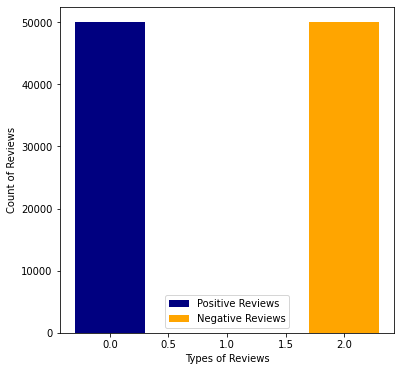

In [33]:
#Count of good and bad reviews
count = df['sentiment'].value_counts()
print('Total Counts of both sets'.format(),count)

print("==============")
#Creating a function to plot the counts using matplotlib
def plot_counts(count_good,count_bad):
    plt.rcParams['figure.figsize']=(6,6)
    plt.bar(0,count_good,width=0.6,label='Positive Reviews',color='Navy')
    plt.legend()
    plt.bar(2,count_bad,width=0.6,label='Negative Reviews',color='Orange')
    plt.legend()
    plt.ylabel('Count of Reviews')
    plt.xlabel('Types of Reviews')
    plt.show()
    
count_good = df['sentiment']=='positive'
count_bad = df['sentiment']=='negative'
plot_counts(len(count_good),len(count_bad))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


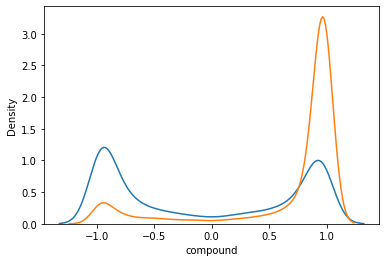

In [ ]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = df[df['sentiment'] == x]
    
    # Draw the density plot
    if x == 1:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'],hist = False, label = label)
    

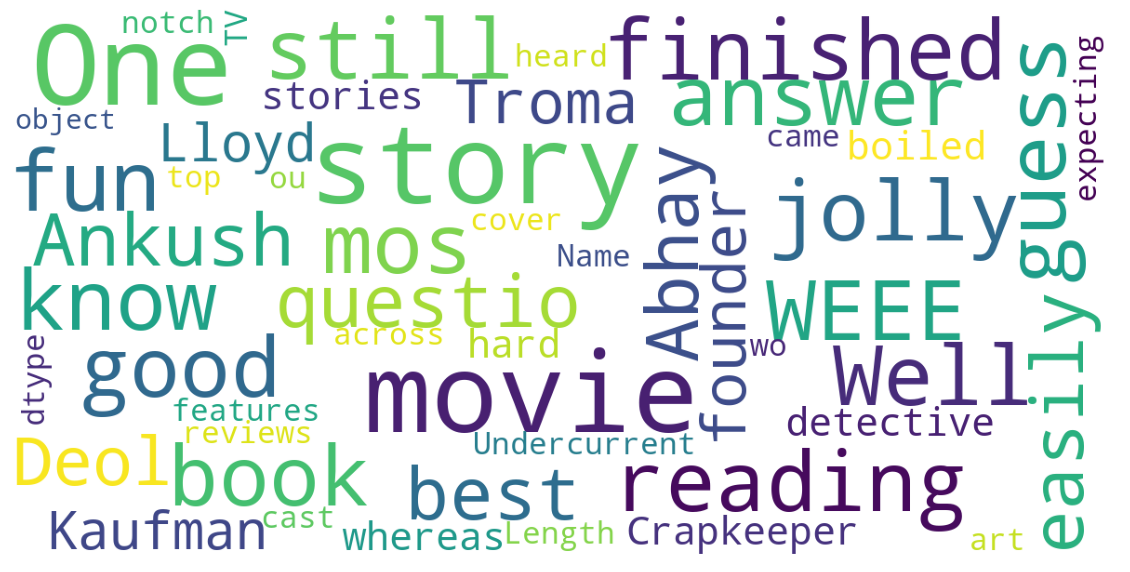

In [ ]:
# wordcloud function
#method copied - props to rohinramachandran

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df["reviews"])

In [ ]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

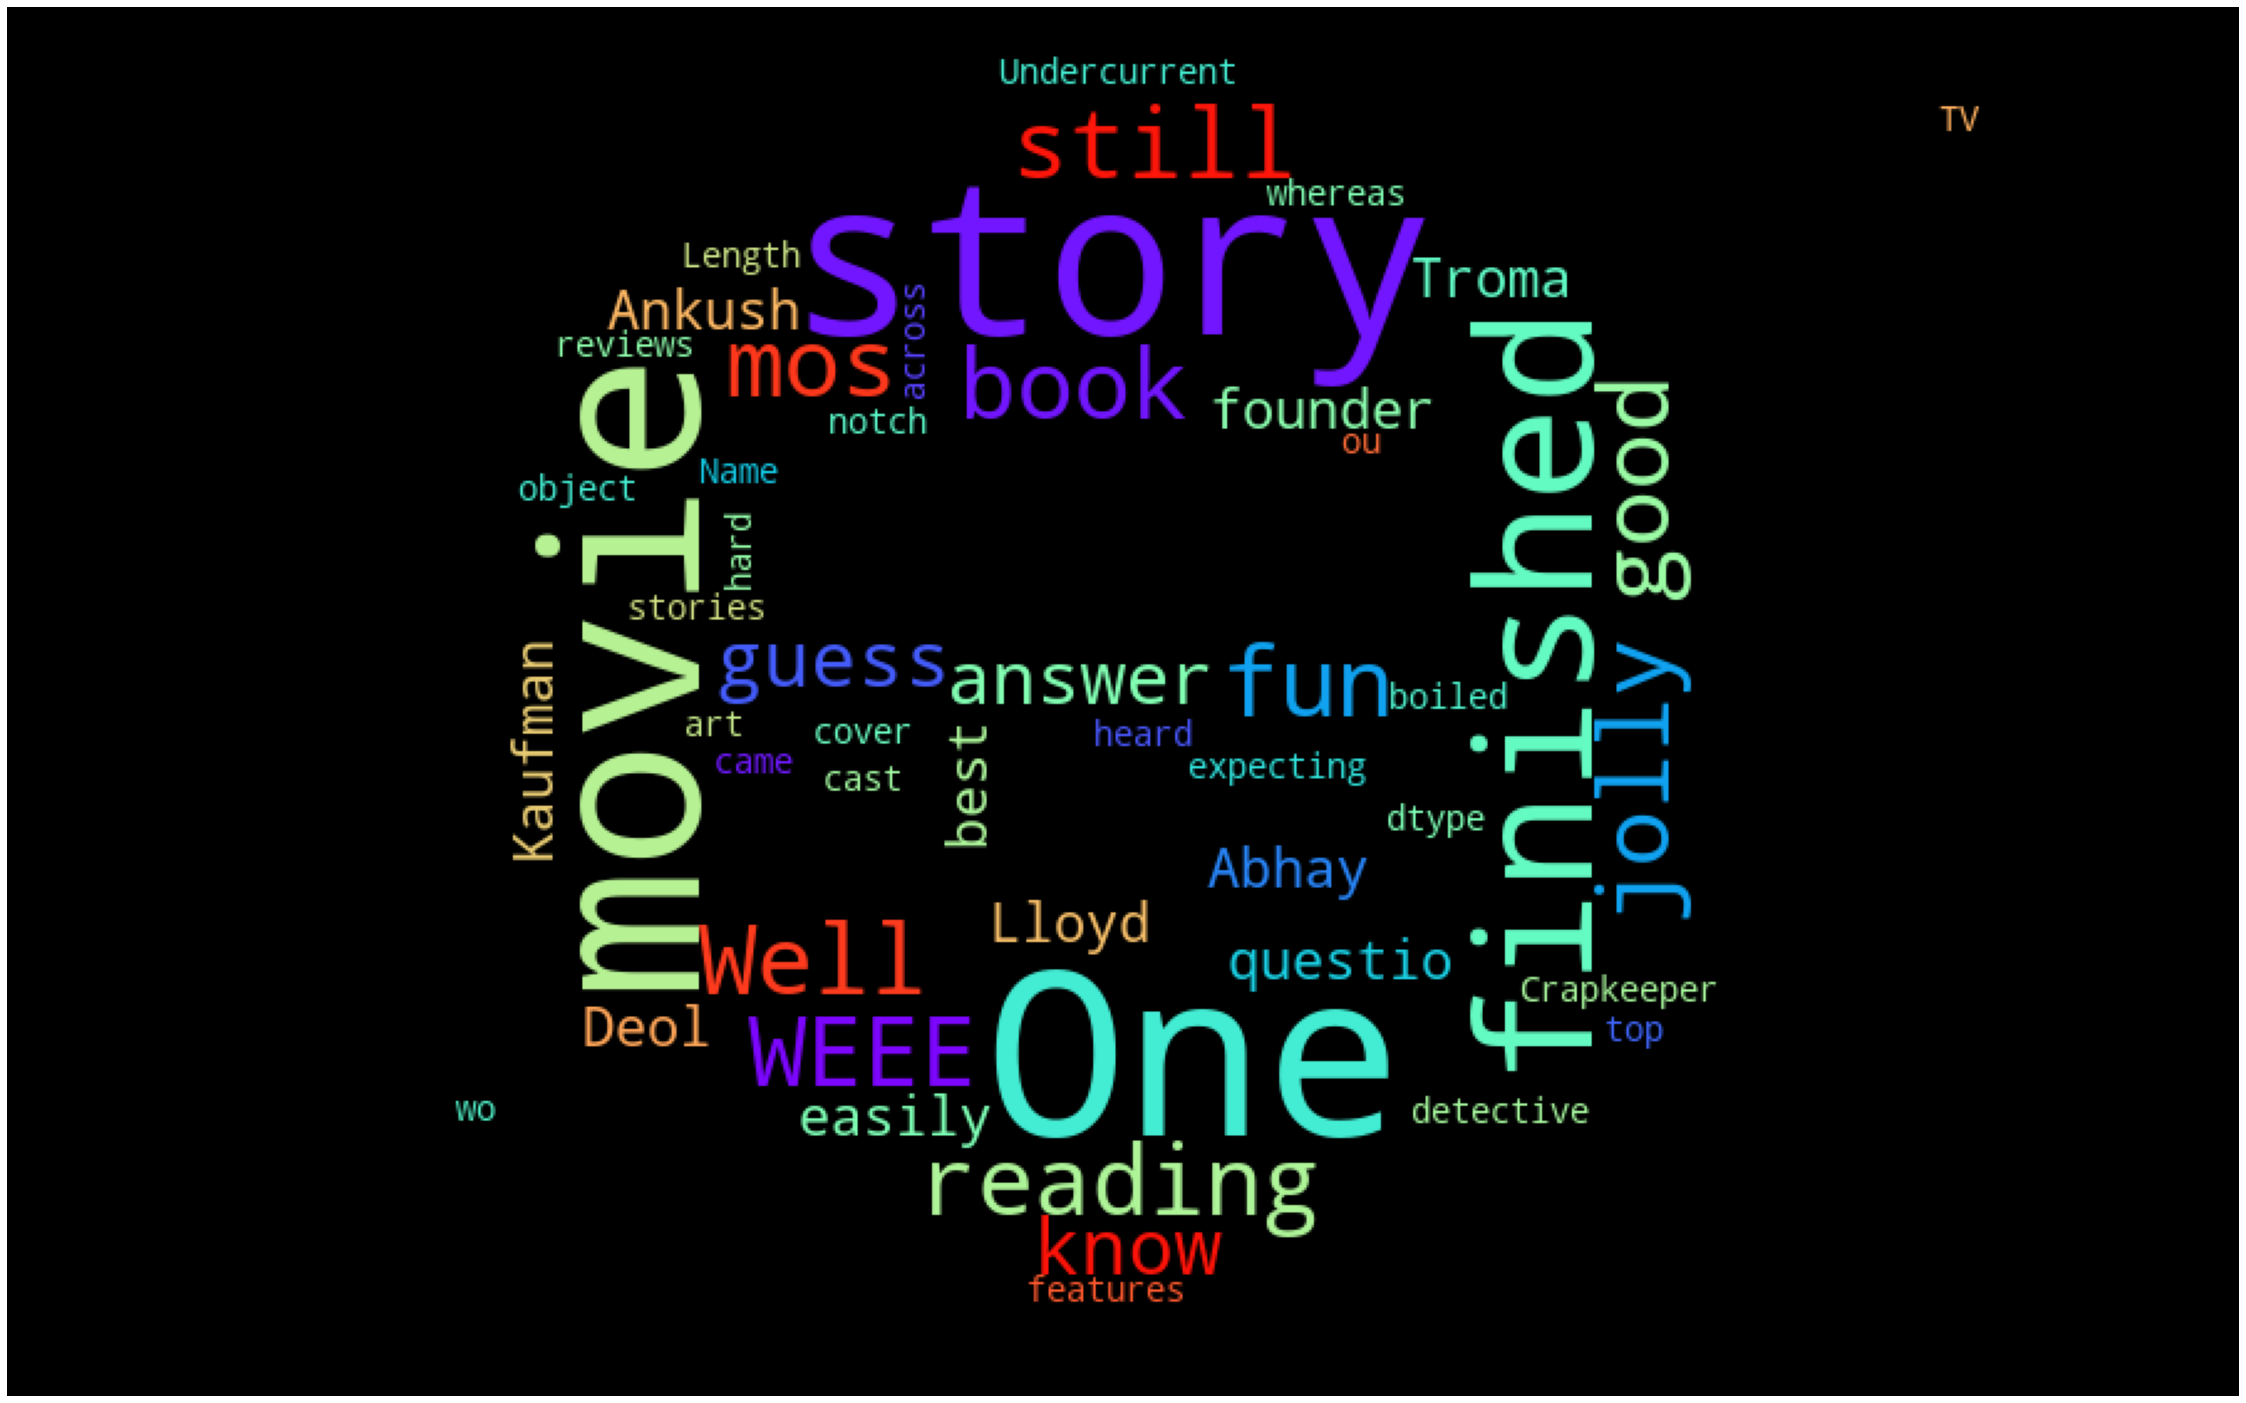

In [ ]:
# Import packages
import numpy as np
from PIL import Image
# Import image to np.array
mask = np.array(Image.open('/content/drive/MyDrive/ironhack_final_project/ironhack.jpg'))
# Generate wordcloud
wordcloud = WordCloud(width = 200, height = 100, random_state=1, background_color='black', colormap='rainbow', collocations=False, stopwords = STOPWORDS, mask=mask).generate(str(df["reviews"]))
# Plot
plot_cloud(wordcloud)

In [ ]:
# Save image
wordcloud.to_file("wordcloud.png")

### Train Model 

In [ ]:
# feature selection
y_label = "sentiment"
#features = df.drop(label,"review", "review_clean",axis=1)
drop_cols = [y_label, "reviews", "review_clean"]
X_features = [column for column in df.columns if column not in drop_cols]



In [ ]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df[X_features], df[y_label], test_size = 0.33, random_state = 42)

In [ ]:
# train a random forest classifier
#rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
#rfc.fit(X_train, y_train)
#pred = rfc.predict(X_test)

KeyboardInterrupt: ignored

In [ ]:
#pickle model
#import joblib,os
#filename = 'finalized_model.sav'
#joblib.dump(rfc, filename)

In [ ]:
# load the model from disk
filename = 'ironhack_final_project/Data/finalized_model.sav'
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

In [ ]:
# show confusion matrix
print(classification_report(y_test, pred))
print(accuracy_score(y_test, pred))

In [ ]:
disp = plot_confusion_matrix(rfc, X_test, y_test,
                     display_labels= ["Negative", 'Positive'])

disp.ax_.set_title("Confusion Matrix \n Random Forest")

In [ ]:
# show feature importance
feature_importances_df = pd.DataFrame({"feature": X_features, "importance": rfc.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(10)

In [ ]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rfc.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

This seems to be goood!!!!

In [ ]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
#from sklearn.utils.fixes import signature

In [ ]:
try:
    from inspect import signature
except ImportError:
    from sklearn.externals.funcsigs import signature

In [ ]:
average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

cls_lst = [GaussianNB(),
           RandomForestClassifier(),
           ]

def evaluate(df, cls):
    accuracies = {}
    
    for cl in cls:

        # feature selection
        y_label = "sentiment"
        #features = df.drop(label,"review", "review_clean",axis=1)
        drop_cols = [y_label, "reviews", "review_clean"]
        X_features = [column for column in df.columns if column not in drop_cols]

        X_train, X_test, y_train, y_test = train_test_split(df[X_features], df[y_label], test_size = 0.33, random_state = 42)
    
        cl.fit(X_train, y_train)
        pred = cl.predict(X_test)
        # print(classification_report(y_test, pred))
        accuracies[cl.__class__.__name__] = accuracy_score(y_test, pred)
        #print(accuracy_score(y_test, pred))
    return accuracies


In [ ]:
accuracy_dict = evaluate(df, cls_lst)

In [ ]:
accuracy_df = pd.DataFrame(accuracy_dict, index=[0])

In [ ]:
accuracy_df.T.plot(kind='bar')

In [ ]:
cls_lst_v2 = [SVC(),RandomForestClassifier()]
accuracy_dict_v2 = evaluate(df, cls_lst_v2)

In [ ]:
accuracy_df_v2 = pd.DataFrame(accuracy_dict_v2, index=[0])

In [ ]:
accuracy_df_v2.T.plot(kind='bar')

In [ ]:
cls_lst_v3 = [DecisionTreeClassifier(),RandomForestClassifier()
accuracy_dict_v3 = evaluate(df, cls_lst_3)

In [ ]:
accuracy_df_v3 = pd.DataFrame(accuracy_dict_v3, index=[0])

## Test Model

In [ ]:
test_text = "This movie was great. It's better than the first in my opinion.I would recommend to any Star Wars fan!!!"

In [ ]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):

    '''
    Function to return the corresponding wordnet object value of the 
    'Part Of Speach tag' i.e "thing : NN" corresponds to Noun in wordnet.
    Input: string (pos tag)
    Output: string (a wordnet object)
    '''

    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
import re
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def review_cleaner(review):

    '''
    Function to convert a review to a tokenised string of words.
    Input: string (a raw movie review)
    Output: string (a preprocessed movie review)
    '''

    # lower review
    review = review.lower()
    # split by just words
    review = re.split(r'\W+',review)
    review = " ".join(review)
    # tokenize review and remove puncutation
    review = [word.strip(string.punctuation) for word in review.split(" ")]
    # remove words that contain numbers
    review = [word for word in review if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    review = [x for x in review if x not in stop]
    # remove empty tokens
    review = [token for token in review if len(token) > 0]
    # pos tag review
    pos_tags = pos_tag(review)
    # lemmatize review
    review = [WordNetLemmatizer().lemmatize(token[0], get_wordnet_pos(token[1])) for token in pos_tags]
    # remove words with only one letter
    review = [token for token in review if len(token) > 1]
    # join all
    review = " ".join(review)
    return {"review_clean":review}

In [ ]:
def get_polarity(text):

    """
    Input: Text as <string>

    Returns:
    Polarity score as dictionary
    """
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)

In [ ]:
def get_char_len(text):

    """
    Input: Text as <string>

    Returns:
    No. of characters in string as <int>
    """
    return{"nb_char":len(text)}


In [ ]:
def get_word_len(text):

    """
    Input: Text as <string>

    Returns:
    No. of words in string as <int>
    """
    return{"nb_words":len(text.split(" "))}

In [ ]:
my_list = [review_cleaner(test_text),get_polarity(test_text),get_char_len(test_text),get_word_len(test_text)]
def update_return(dct1, dct2):
    dct1.update(dct2)
    return dct1
result_dict = functools.reduce(lambda x,y: update_return(x,y), my_list)
review_df = pd.DataFrame(result_dict,index=[0])

In [ ]:
#review_df

In [ ]:
def doc_2_vec(review_df):
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(review_df["review_clean"].apply(lambda x: x.split(" ")))]
    # train a Doc2Vec model with text data
    model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
    # transform each document into a vector data
    doc2vec_df = review_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
    doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
    review_df_doc = pd.concat([review_df, doc2vec_df], axis=1)
    return review_df_doc
       

In [ ]:
review_df_doc = doc_2_vec(review_df)

In [ ]:
review_df_doc

In [ ]:
# add tf-idfs columns
#def tfidf_vec(review_df_doc):
    #tfidf = TfidfVectorizer(min_df = 1)
    #tfidf_result = tfidf.fit_transform(review_df_doc["review_clean"]).toarray()
    #tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
    #tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
    #review_df_vec = pd.concat([review_df_doc, tfidf_df], axis=1)
    #return review_df_vec

In [ ]:
def load_tfidf(vector_file):
    tfidf_df = pd.read_pickle(vector_file)
    review_df_vec = pd.concat([review_df_doc, tfidf_df], axis=1)
    return review_df_vec

In [ ]:
review_vector = load_tfidf('final_project/Data/Imdb_tfidf.pckl')

In [ ]:
#review_vector = tfidf_vec(review_df_doc)

In [ ]:
review_vector

In [ ]:
final_df = review_vector.drop("review_clean",axis=1)

In [ ]:
final_df.shape

(50000, 5189)

In [ ]:
final_df = final_df.fillna(0)

In [ ]:
# load the model from disk
filename = 'final_project/Data/finalized_model.sav'
loaded_model = joblib.load(filename)
#result = loaded_model.score(X_test, y_test)
#print(result)

In [ ]:
loaded_model.predict(final_df)

array([1, 1, 0, ..., 0, 0, 1])

In [ ]:
len(loaded_model.predict(final_df))

50000